In [1]:
%load_ext autoreload
%autoreload 2 

In [2]:
from fastai.tabular.all import * 
from mock import Mock
from tabnet.utils import *
from tabnet.model import *

In [3]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

In [17]:
class LinDecoder(Module):
    def __init__(self, n_cat, n_cont, cats, ps=0.1, n_steps=5, n_d=12, **kwargs):
        store_attr()
        self.activation_cats = sum([v for k,v in cats.items()])
        
        self.decoder = nn.Sequential(
            LinBnDrop(n_d, 256, p=ps, act=Mish()),
            LinBnDrop(256, 512, p=ps, act=Mish()),
            LinBnDrop(512, 1024, p=ps, act=Mish())
        )
        
        self.decoder_cont = nn.Sequential(
            LinBnDrop(1024, n_cont, p=ps, bn=False, act=None),
        )
        
        self.decoder_cat = LinBnDrop(1024, self.activation_cats, p=ps, bn=False, act=None)

        
    def forward(self, x):
        xs = x.sum(dim=1)
        decoded = self.decoder(xs)
        decoded_cats = self.decoder_cat(decoded)
        decoded_conts = self.decoder_cont(decoded)

        return decoded_cats, decoded_conts

In [18]:
class RecreatedLoss(Module):
    "Measures how well we have created the original tabular inputs"
    def __init__(self, cat_dict):
        ce = CrossEntropyLossFlat(reduction='sum')
        mse = MSELossFlat(reduction='sum')
        store_attr('cat_dict,ce,mse')

    def forward(self, preds, cat_targs, cont_targs):
        cats, conts = preds
        tot_ce, pos = cats.new([0]), 0
        for i, (k,v) in enumerate(self.cat_dict.items()):
            tot_ce += self.ce(cats[:, pos:pos+v], cat_targs[:,i])
            pos += v
        
        norm_cats = cats.new([len(self.cat_dict)])
        norm_conts = conts.new([conts.size(1)])
        cat_loss = tot_ce/norm_cats
        cont_loss = self.mse(conts, cont_targs)/norm_conts
        total = cat_loss+cont_loss

        return total / cats.size(0)

In [19]:
def lin_decoder(n_cat, n_cont, **kwargs):
    return LinDecoder(n_cat, n_cont, **kwargs)

# Tests

### SS Forest

In [20]:
data_dir = Path('./data')

In [21]:
def extract_gzip(file, dest=None):
    import gzip
    dest = dest or Path(dest)
    with gzip.open(file, 'rb') as f_in:
        with open(dest / file.stem, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

In [22]:
forest_type_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz'
forest_path = untar_data(forest_type_url, dest=data_dir, extract_func=extract_gzip)

In [23]:
target = "Covertype"

cat_names = [
    "Wilderness_Area1", "Wilderness_Area2", "Wilderness_Area3",
    "Wilderness_Area4", "Soil_Type1", "Soil_Type2", "Soil_Type3", "Soil_Type4",
    "Soil_Type5", "Soil_Type6", "Soil_Type7", "Soil_Type8", "Soil_Type9",
    "Soil_Type10", "Soil_Type11", "Soil_Type12", "Soil_Type13", "Soil_Type14",
    "Soil_Type15", "Soil_Type16", "Soil_Type17", "Soil_Type18", "Soil_Type19",
    "Soil_Type20", "Soil_Type21", "Soil_Type22", "Soil_Type23", "Soil_Type24",
    "Soil_Type25", "Soil_Type26", "Soil_Type27", "Soil_Type28", "Soil_Type29",
    "Soil_Type30", "Soil_Type31", "Soil_Type32", "Soil_Type33", "Soil_Type34",
    "Soil_Type35", "Soil_Type36", "Soil_Type37", "Soil_Type38", "Soil_Type39",
    "Soil_Type40"
]

cont_names = [
    "Elevation", "Aspect", "Slope", "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways",
    "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points"
]

feature_columns = (
    cont_names + cat_names + [target])

params = dict(cont_names = cont_names, y_names = target, cat_names = cat_names)
procs=[Categorify, FillMissing, Normalize]
model_params = dict(n_d=64, n_a=64, n_steps=5, virtual_batch_size=512, gamma=1.5, bs=1024*16,
                    lambda_sparse=1e-4, momentum=0.7, n_shared_ft_blocks=2, n_independent_ft_blocks=2, p=0.5)

In [24]:
df = pd.read_csv(forest_path, header=None, names=feature_columns).sample(n=200_000)
df.shape

(200000, 55)

In [42]:
val_pct = 0.2
curriculum = False


In [43]:
to = tabular_pandas(df, cat_names, cont_names, target, 
                    tabular_type=TabularPandasIdentity, val_pct=val_pct)
total_cats = {k:len(v) for k,v in to.classes.items()}
loss_func = RecreatedLoss(total_cats)

head = lambda n_cat, n_cont, **kwargs: LinDecoder(n_cat, n_cont, total_cats, **kwargs)

In [44]:
dls = to.dataloaders(bs=model_params['bs'])
dls.n_inp = 2
cbs = [SetPrior(), TabularMasking(p=model_params['p'], curriculum=curriculum)]
model = TabNetSelfSupervised(head, to, **model_params)

In [45]:
learn = Learner(dls, model, cbs=cbs, loss_func=loss_func)

SuggestedLRs(lr_min=0.0013182567432522773, lr_steep=0.0014454397605732083)

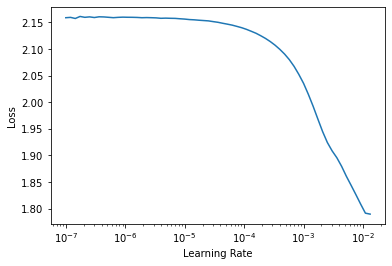

In [29]:
learn.lr_find()

In [46]:
learn.fit_one_cycle(40, slice(1e-3, 1e-2))

epoch,train_loss,valid_loss,time
0,1.908894,1.869574,00:04
1,1.588906,1.142516,00:04
2,1.424069,1.044721,00:04
3,1.317930,0.987346,00:04
4,1.231175,0.944578,00:04
5,1.156902,0.779229,00:04
6,1.120852,1.942854,00:04
7,1.427257,2.502808,00:04
8,1.429573,1.336167,00:04
9,1.368324,1.089032,00:04


In [54]:
l = tabnet_df_classifier(df, **params, enc=learn.model.enc, val_pct=0.99, **model_params)

In [52]:
l.dls.train.bs = l.dls.train.n//2 if l.dls.train.n < model_params['bs'] else model_params['bs']

SuggestedLRs(lr_min=0.15848932266235352, lr_steep=0.0063095735386013985)

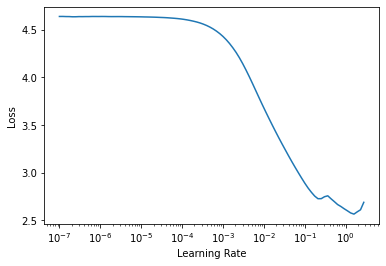

In [38]:
l.lr_find()

In [53]:
l.fit_one_cycle(30, slice(5e-3, 1e-1))

epoch,train_loss,valid_loss,accuracy,time
0,3.538095,2.258275,0.417500,00:01
1,2.758635,1.293380,0.564470,00:01
2,2.199159,1.458296,0.610864,00:01
3,1.890119,1.304058,0.510970,00:01
4,1.681231,3.667667,0.321803,00:01
5,1.542480,7.030847,0.345520,00:01
6,1.505374,7.981726,0.327152,00:01
7,1.439189,1.845523,0.506364,00:01
8,1.373092,1.128844,0.618273,00:01
9,1.307479,1.112017,0.628803,00:01


In [33]:
dl = learn.dls.test_dl(df)
preds, targs = learn.get_preds(dl=dl)

In [ ]:
for p, t in zip(preds[0].tolist(), targs[0].tolist()):
    print(p, t)

### SS Flowers

In [ ]:
data = load_iris()
X,y = data['data'], data['target']
cont_names = ['s_len', 's_wid', 'p_len', 'p_wid']
cat_names = []
y_names = 'target'
df = pd.concat([pd.DataFrame(X, columns=cont_names),
           pd.DataFrame(y, columns=[y_names])], axis=1)

In [ ]:
model_params = dict(n_d=16, n_a=16, n_steps=3, virtual_batch_size=4, gamma=1.5, bs=32,
                    lambda_sparse=1e-4, momentum=0.7, n_shared_ft_blocks=2, n_independent_ft_blocks=0, p=0.3)
val_pct = 0.2
curriculum = False
head = lambda n_out, **kwargs: LinDecoder(n_out, **kwargs)
loss_func = MSELossFlat()

In [ ]:
to = tabular_pandas(df, cat_names, cont_names, y_names, tabular_type=TabularPandasIdentity, val_pct=val_pct)
dls = to.dataloaders(bs=model_params['bs'])
dls.n_inp = 2
cbs = [SetPrior(), TabularMasking(p=model_params['p'], curriculum=curriculum),
       MaskRegularizer(model_params['lambda_sparse'])]
model = TabNetSelfSupervised(head, to, **model_params)

In [ ]:
learn = Learner(dls, model, cbs=cbs, loss_func=loss_func, metrics=[mse])

In [ ]:
learn.dls.cpu()

In [ ]:
learn.fit_one_cycle(30, slice(1e-4, 1e-3))

In [ ]:
dl = learn.dls.test_dl(df)
preds, targs = learn.get_preds(dl=dl)

In [ ]:
preds[0][:10], targs[0][:10]

### BaseLine

In [ ]:
splits = RandomSplitter()(range_of(df))
dls = TabularPandas(df, cat_names=[], cont_names=['s_len', 's_wid', 'p_len', 'p_wid'], splits=splits,
              procs=[Categorify, FillMissing, Normalize], y_names='target', y_block=CategoryBlock()).dataloaders(bs=4)

In [ ]:
learn = tabular_learner(dls, metrics=[accuracy])

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(20, 1e-2)

### TabNet

In [ ]:
model_params = dict(n_d=16, n_a=16, n_steps=5, virtual_batch_size=512, gamma=1.5, bs=30,
                    lambda_sparse=1e-4, momentum=0.7, n_shared_ft_blocks=2, n_independent_ft_blocks=2)

In [ ]:
learn = tabnet_df_classifier(df, cat_names=[], cont_names=['s_len', 's_wid', 'p_len', 'p_wid'],
                                                     y_names='target', val_pct=0.2, **model_params)

In [ ]:
learn.summary()

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(10, 1e-2)

# Export

In [ ]:
from nbdev.export import notebook2script
notebook2script()